In [1]:
import tensorflow.keras as keras
# 심층 신경망을 훈련 시의 문제
# 1. 기울기 소실 / 기울기 폭발 문제
# 2. 훈련 데이터 부족 또는 레이블 생성 문제
# 3. 훈련 속도 극단적으로 느림
# 4. 수백만 개의 파라미터를 가진 모델은 훈련 세트에 과대적합될 위험이 크다.
## (특히 훈련 샘플이 충분치 않거나, 잡음이 많을 경우)

## 기울기 소실 과 폭주 문제

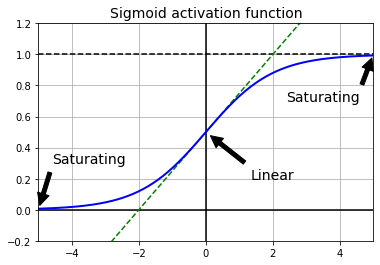

In [ ]:
# 오차역전파로 신경망의 모든 파라미터에 대한 오차 함수의 기울기 값을 계산하면
## 경사 하강법 단계에서 이 기울기를 사용하여 각 파라미터를 수정한다.

# 알고리즘이 하위층으로 진행될 수록 기울기값이 점점 작아지는 경우가 많다. => 기울기 소실
# 기울기가 점점 커져서 여러 층이 비정상적으로 큰 가중치로 갱신되면 알고리즘은 발산한다. => 기울기 폭주
## (순환 신경망에서 주로 나타난다.)

# 의심되는 원인 : 로지스틱 시그모이드 활성화 함수 / 가중치 초기화 방법
## => 각 층에서 출력의 분산이 입력의 분산보다 더 크다는 것이 밝혀짐.
## (신경망의 위쪽으로 갈 수록 층을 지날 때마다 분산이 게속 커져 가장 높은 층에서는 활성화함수가 0이나 1로 수렴)
### why? 시그모이드의 평균이 0이 아니고, 0.5이기 때문.

import matplotlib.pyplot as plt
import numpy as np

def logit(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

### 글로럿과 He 초기화

In [ ]:
# 케라스는 기본적으로 균등분포의 글로럿 초기화를 사용한다.

import tensorflow.keras as keras
# 초기화 방법들...
[name for name in dir(keras.initializers) if not name.startswith("_")]

In [ ]:
keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal')
# 층을 만들 때, kernel_initializer='he_uniform' 또는 'he_normal' 을 사용하여 He 초기화를 사용 가능

In [ ]:
# fan-out 기반의 균등분포 He 초기화 사용 시 VarianceScaling을 사용할 수 있다.
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg', distribution='uniform')
keras.layers.Dense(10, activation='relu', kernel_initializer=init)

### 수렴하지 않는 활성화 함수

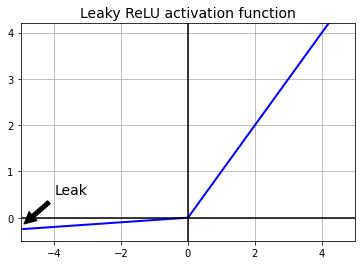

In [ ]:
# Relu 함수는 특정 양수값에 수렴하지 않는다는 장점이 있으나,
# 훈련하는 동안 일부 뉴런이 0 이외의 값을 출력하지 않는 문제가 발생할 수 있다.
# (입력의 가중치 합이 음수가 되면 뉴런이 죽는다.) => 경사하강법이 동작하지 않는다.

# 이를 해결하기 위해 LeakyReLu 같은 ReLu 함수의 변종을 사용한다.
# LeakyReLU(z) = max(az , z)
# a : 새는 정도. z < 0 일때의 함수의 기울기. 일반적으로 0.01로 설정한다.

# RReLU : 훈련하는 동안 주어진 범위에서 a 를 무작위로 선택하고 테스트시에는 평균을 사용
## 규제의 역할을 하는 것처럼 보였다고 한다.

# PReLU : a가 '학습되는 동안 학습되는' 

def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

In [11]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
# LeakyReLU 사용
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.SGD(learning_rate = 1e-3))

In [ ]:
history = model.fit(X_train, y_train , epochs = 10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 1.5990 - val_loss: 0.8712
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.8332 - val_loss: 0.7122
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7004 - val_loss: 0.6392
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6312 - val_loss: 0.5942
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5934 - val_loss: 0.5609
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5615 - val_loss: 0.5360
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5439 - val_loss: 0.5201
Epoch 8/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5230 - val_loss: 0.5055
Epoch 9/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5108 - val_loss: 0.4974
Epoch 10/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.502

In [ ]:
# PReLU 사용
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3))

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 1.7019 - val_loss: 0.9075
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.8572 - val_loss: 0.7158
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7031 - val_loss: 0.6346
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6322 - val_loss: 0.5849
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5852 - val_loss: 0.5545
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5588 - val_loss: 0.5326
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5344 - val_loss: 0.5128
Epoch 8/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5192 - val_loss: 0.4999
Epoch 9/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5084 - val_loss: 0.4864
Epoch 10/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.494

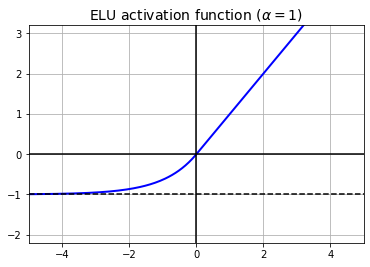

In [ ]:
# ELU 활성화 함수
# ReLU 변종의 성능을 넘어섬. 훈련 시간이 줄고, 신경망의 테스트 세트 성능도 더 높았다.

# ReLU 와의 차이점
# 1. z < 0 일때 음수값이 들어오면서 활성화 함수의 평균 출력이 0에 더 가까워진다.
## (기울기 소실 문제 완화)
# 2. z < 0 이어도 기울기가 0이 아니므로 죽은 뉴런이 생기지 않는다.
# 3. alpha가 1 이면 z = 0 에서 급격하게 변동되지 않아 모든 구간에서 매끄러워 경사 하강법의 속도가 올라간다.

# 단점 : 지수함수를 사용하여 ReLU 시리즈보다 계산이 느리다.
# (훈련하는 동안 수렴 속도가 빨라서 느린 계산이 상쇄되지만, 테스트 시에는 ELU가 더 느림.)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

In [ ]:
# 층을 만들 때, 활성화 함수로 지정하여 쉽게 사용 가능하다.
keras.layers.Dense(10, activation="elu")

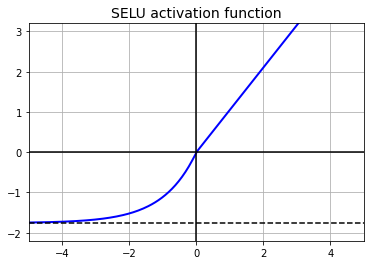

In [ ]:
# SELU 활성화 함수 (ELU의 변종)
# 완전연결층만 쌓아서 신경망을 만들고, 모든 은닉층이 SELU 활성화 함수를 사용한다면
# 네트워크가 자기 정규화 된다는 것을 발견하였다.
# 훈련하는 동안 각 층의 출력이 평균 0과 표준편차 1을 유지하는 경향이 있다.
## => 기울기 소실과 폭주 문제를 막아준다.
# 아주 깊은 네트워크에서 다른 활성화 함수보다 뛰어난 성능을 종종 낸다.

# 자기 정규화가 일어나기 위한 조건
# 1. 입력특성이 반드시 표준화 되어야 한다.
# 2. 모든 은닉층의 가중치를 르쿤 정규분포 초기화로 초기화 해야 한다.
# (kernel_initializer = 'lecun_normal')
# 3. 네트워크가 일렬로 쌓은 층으로 구성되어야 한다.
# (순환 신경망, 스킵 연결 에서는 보장되지 않는다.)

from scipy.special import erfc

# alpha와 scale은 평균 0과 표준 편차 1로 자기 정규화합니다
# (논문에 있는 식 14 참조):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

In [ ]:
# 층을 만들 때, 활성화 함수로 지정하여 쉽게 사용 가능하다.
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

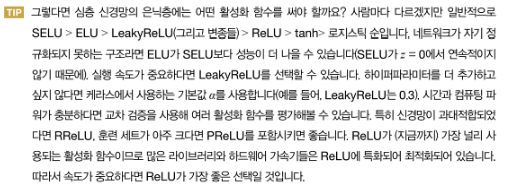

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [14]:
# 입력을 평균 0과 표준편차 1로 바꾼다.
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 30s 16ms/step - loss: 1.3206 - accuracy: 0.5117 - val_loss: 0.7175 - val_accuracy: 0.7490
Epoch 2/5
1719/1719 [==============================] - 27s 16ms/step - loss: 0.6801 - accuracy: 0.7592 - val_loss: 0.6277 - val_accuracy: 0.7776
Epoch 3/5
1719/1719 [==============================] - 27s 16ms/step - loss: 0.5669 - accuracy: 0.7956 - val_loss: 0.5567 - val_accuracy: 0.8048
Epoch 4/5
1719/1719 [==============================] - 27s 16ms/step - loss: 0.5270 - accuracy: 0.8186 - val_loss: 0.4878 - val_accuracy: 0.8362
Epoch 5/5
1719/1719 [==============================] - 27s 16ms/step - loss: 0.4798 - accuracy: 0.8344 - val_loss: 0.4525 - val_accuracy: 0.8432


### 배치 정규화

In [ ]:
# 각 층에서 활성화 함수를 토과하기 전이나 후에 모델에 연산을 하나 추가한다.
# 입력을 원점에 맞추고 정규화한 다음, 각 층에서 두개의 새로운 파라미터로 결괏값의 스케일을 조정하고 이동시킨다.
# 하나는 스케일 조정에, 다른 하나는 이동에 사용한다.
# 많은 경우 신경망의 첫 번째 층으로 배치 정규화를 추가하면 훈련 세트를 표준할 필요가 없다.

# 케라스의 BatchNormalization 층은 이를 자동으로 수행한다.

# 배치 정규화는 규제와 같은 역할을 하여 다른 규제 기법의 필요성을 줄여준다.

# 그러나 배치 정규화는 모델의 복잡도를 키운다. 실행 시간 면에서도 손해이다.
# 층마다 추가되는 계산이 신경망의 예측을 느리게 한다.

# BatchNormalization 층을 추가함으로 써 쉽게 사용할 수 있다.

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

model.summary()

# BatchNormalization 층은 입력마다 네 개의 파라미터를 추가한다.
# 출력 스케일벡터, 출력 이동벡터 , 최종 입력 평균 벡터, 최종 입력 표준편차 벡터

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_112 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_113 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_114 (Dense)            (None, 10)               

In [ ]:
# 출력 스케일벡터, 출력 이동벡터는 훈련되고,
# 최종 입력 평균 벡터, 최종 입력 표준편차 벡터는 훈련되지 않는다.
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs =10 , validation_data = (X_valid , y_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 6ms/step - loss: 1.2098 - accuracy: 0.5973 - val_loss: 0.5622 - val_accuracy: 0.8096
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5966 - accuracy: 0.7956 - val_loss: 0.4843 - val_accuracy: 0.8316
Epoch 3/10
1719/1719 [==============================] - 9s 6ms/step - loss: 0.5243 - accuracy: 0.8147 - val_loss: 0.4465 - val_accuracy: 0.8420
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4837 - accuracy: 0.8298 - val_loss: 0.4240 - val_accuracy: 0.8508
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4647 - accuracy: 0.8372 - val_loss: 0.4093 - val_accuracy: 0.8562
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4376 - accuracy: 0.8478 - val_loss: 0.3963 - val_accuracy: 0.8582
Epoch 7/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4267 - accuracy: 0.8494 - val_loss: 0.3868 - val_accu

논문의 저자들은 활성화 함수 이전에 배치 정규화 층을 추가하는 것이 좋다고 조언한다. 
<br>
BatchNormalization 층 이전의 층은 편향을 위한 항이 필요 없다.
<br>
(BatchNormalization 층이 이를 무효화하기 때문)
<br>
use_bias=False 를 지정하여 층을 만든다.
```
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])
```



### 기울기 클리핑

In [ ]:
# 역전파 될때 일정 임계값을 넘어서지 못하게 기울기를 잘라내는 것.
# 순환 신경망은 배치정규화를 적용하기 어려워서 이 방법을 많이 사용한다.
# 다른 종류의 네트워크는 배치정규화면 충분하다.

optimizer = keras.optimizers.SGD(clipvalue = 1.0)
model.compile(loss='mse', optimizer= optimizer)
# 기울기 벡터의 모든 원소를 -1.0 과 1.0 사이로 클리핑 한다.
# => 손실의 모든 편미분 값을 -1.0 에서 1.0으로 잘라낸다.
# ex) gradient_vector =  [0.9 , 100.0] ==> [0.9, 1.0]


# 기울기 클리핑이 기울기 벡터의 방향을 바꾸지 못하게 하려면
# clipvalue 대신 clipnorm을 지정하여 노름으로 클리핑 해야 한다.
optimizer = keras.optimizers.SGD(clipnorm=1.0)
# ex) gradient_vector = [0.9, 100.0] = > [0.008999964, 0.9999595]

## 사전훈련된 층 재사용하기

### 케라스를 사용한 전이 학습

In [ ]:
# 해결하려는 것과 비슷한 유형의 문제를 처리한 신경망이 이미 있는지 찾아본 다음
## 그 신경망의 하위층을 재사용하는 것을 전이학습이라 한다.
## => 훈련 속도를 크게 높일 뿐만 아니라 필요한 훈련 데이터도 크게 줄여준다.

# 1. 먼저 재사용하는 층을 모두 동결한다.
# 2. 모델을 훈련하고 성능을 평가한다.
# 3. 맨 위에 있는 한두개의 은닉층의 동결을 해제한다.
# 4. 역전파를 통해 가중치를 조정하여 성능이 향상되는지 확인한다.
## (훈련 데이터가 많을 수록 많은 층의 동결을 해제할 수 있다.)
## (재사용 층의 동결을 해제할 때는 학습률을 줄이는 것이 좋다.)
# 5. 여전히 좋은 성능을 낼수 없다면 상위 은닉층들을 제거하고 남은 은닉층을 다시 동결한다.
# 6. 재사용할 은닉층의 적절한 갯수를 찾을 때까지 반복한다.

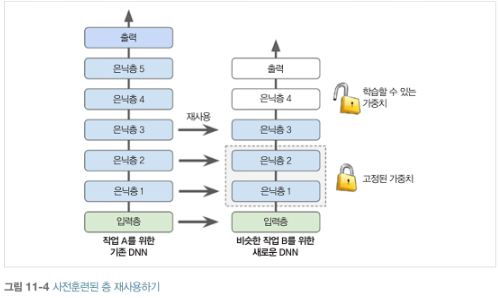

In [ ]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

#X_train_A: 샌달과 셔츠(클래스 5와 6)을 제외한 모든 이미지
#X_train_B: 샌달과 셔츠 이미지 중 처음 200개만 가진 작은 훈련 세트

In [ ]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

In [ ]:
model_A.save("my_model_A.h5")

In [ ]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

In [ ]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
# 모델 A의 출력층을 제외한 모든 층을 재사용한다.
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))
# 출력층 생성

In [ ]:
model_A_clone = keras.models.clone_model(model_A)
# model_B_on_A 를 훈련할 때 model_A 도 영향을 받는다.
# 이를 방지하기 위해 재사용 전 model_A를 클론한다. (구조 복제)
model_A_clone.set_weights(model_A.get_weights())
# 가중치 복사

In [ ]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

# 새로운 출력층이 랜덤하게 초기화 되어 있어, 큰 오차를 만들 수 있다.
# => 큰 오차가 재사용된 가중치를 망칠 수 있다.
# => 처음 몇번의 에포크 동안 재사용된 층을 동결하고 새로운 층에게 적절한 가중치를 학습할 시간을 준다.

# 층을 동결하거나 동결을 해제한 후 반드시 모델을 컴파일 해야 한다.

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

In [ ]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))
# 동결된 상태로 4 에포크 동안 학습한다.
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

# 4 에포크가 종료 된 후 동결을 해제, 컴파일 한뒤 16 에포크 동안 학습한다.

Epoch 1/4
7/7 [==============================] - 1s 40ms/step - loss: 0.3381 - accuracy: 0.8669 - val_loss: 0.3382 - val_accuracy: 0.8732
Epoch 2/4
7/7 [==============================] - 0s 16ms/step - loss: 0.3117 - accuracy: 0.8927 - val_loss: 0.3251 - val_accuracy: 0.8813
Epoch 3/4
7/7 [==============================] - 0s 16ms/step - loss: 0.3020 - accuracy: 0.8800 - val_loss: 0.3123 - val_accuracy: 0.8884
Epoch 4/4
7/7 [==============================] - 0s 15ms/step - loss: 0.2884 - accuracy: 0.9330 - val_loss: 0.3000 - val_accuracy: 0.8976
Epoch 1/16
7/7 [==============================] - 1s 42ms/step - loss: 0.2415 - accuracy: 0.9408 - val_loss: 0.2357 - val_accuracy: 0.9371
Epoch 2/16
7/7 [==============================] - 0s 16ms/step - loss: 0.2196 - accuracy: 0.9565 - val_loss: 0.1969 - val_accuracy: 0.9503
Epoch 3/16
7/7 [==============================] - 0s 17ms/step - loss: 0.1725 - accuracy: 0.9815 - val_loss: 0.1667 - val_accuracy: 0.9604
Epoch 4/16
7/7 [===============

In [ ]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.0916 - accuracy: 0.9825


[0.09163115918636322, 0.9825000166893005]

In [ ]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.0614 - accuracy: 0.9950


[0.06144269183278084, 0.9950000047683716]

In [ ]:
# 전이학습은 작은 완전 연결 네트워크에서는 잘 동작하지 않는다.
# 전이학습은 조금 더 일반적인 특성을 감지하는 경향이 있는 심층 합성곱 신경망에서 잘 동작한다.

### 비지도 사전훈련

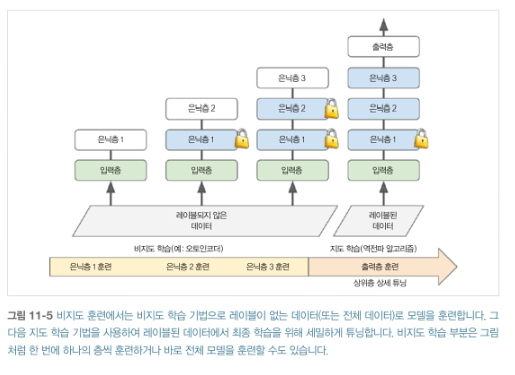

### 보조 작업에서 사전훈련

In [ ]:
# 레이블된 훈련 데이터가 많지 않다면,
# 레이블된 훈련 데이터를 쉽게 얻거나, 생성할 수 있는 보조작업에서 첫번째 신경망을 훈련하는 방법이 있다.
# 이 신경망의 하위층을 실제 작업을 위해 재사용한다.

## 고속 옵티마이저

In [ ]:
# 표준적인 경사 하강법 옵티마이저 대신 더 빠른 옵티마이저를 사용할 수있다.
# 모멘텀 최적화, 네스테로프 가속 경사, AdaGrad, RMSProp, Adam, NAdam

### 모멘텀 최적화

In [ ]:
# 경사하강법은 이전 기울기값이 얼마였는지 고려하지 않으며, 기울기값이 아주 작으면 매우 느려진다.

# 반면 모멘텀 최적화는 이전 기울기값이 얼마였는지를 중요하게 고려한다.
# 매 반복에서 현재 기울기를 학습률을 곱한 뒤, 모멘텀 벡터에 더하고 이값을 빼는 방식으로 가중치를 갱신한다.
# 기울기를 속도가 아닌 가속도로 사용한다.
# 일종의 마찰저항을 표현하고, 모멘텀이 너무 커지는 것을 막기 위해 모멘텀이라는 하이퍼파라미터 beta 를 사용한다.
# => 0~1 사이로 설정되어야 한다. 일반적인 모멘텀 값은 0.9 이다.

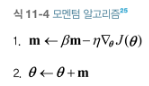

In [ ]:
# 케라스에서 모멘텀 최적화를 구현. SGD 옵티마이저를 사용하고, momentum 매개변수를 지정한다.
optimizer = keras.optimizers.SGD(lr=0.001 , momentum=0.9)

### 네스테로프 가속 경사

In [ ]:
# 모멘텀 최적화의 변종으로 모멘텀 최적화 보다 거의 항상 더 빠르다.
# 현재 위치를 모멘텀의 방향으로 조금 앞선 곳에서 비용함수의 기울기를 계산한다.

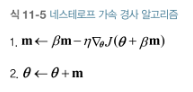

In [ ]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

### AdaGrad

In [ ]:
# 가장 가파른 차원을 따라 기울기 벡터의 스케일을 감소시켜
# 전역 최적점 쪽으로 방향을 잡도록 한다.
# 학습률을 감소시키지만, 경사가 완만한 차원보다 가파른 차원에 대해 더 빠르게 감소된다.
# (적응적 학습률)

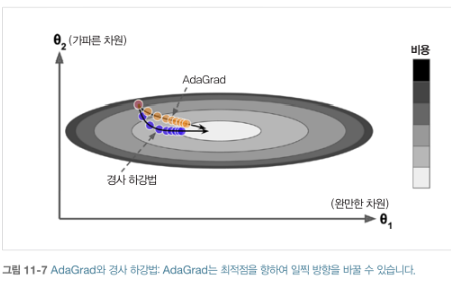

In [ ]:
# 간단한 2차방정식 문제에 대해서는 잘 작동하지만, 신경망을 훈련할 때 너무 일찍 멈추는 경우가 종종 있다.
# 선형 회귀 같은 간단한 작업에는 효과적이나, 심층 신경망에는 사용해선 안된다.

### RMSProp

In [2]:
# 훈련 시작부터의 모든 기울기값이 아닌 가장 최근 반복에서 비롯된 기울기만 누적하여
## AdaGrad의 문제를 해결한 알고리즘. <= 지수 감소를 사용한다.
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

### Adam

In [3]:
# 모멘텀 최적화와 RMSProp의 아이디어를 합친 Adam.
## 모멘텀 최적화 처럼 지난 기울기의 지수 감소 평균을 따르고,
## RMSProp처럼 지난 기울기 제곱의 지수감소된 평균을 따른다.

optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2 = 0.999)
# 모멘텀감쇠 하이퍼파라미터 베타1은 보통 0.9로 초기화하고, 
# 스케일감쇠 하이퍼파라미터 베타2는 0.999로 초기화하는 경우가 많다.

# AdaGrad나 RMSProp 처럼 적응적 학습률 알고리즘이기 때문에, 학습률 하이퍼파라미터를 튜닝할 필요가 없다.
# 일반적으로 0.001을 일반적으로 사용한다.

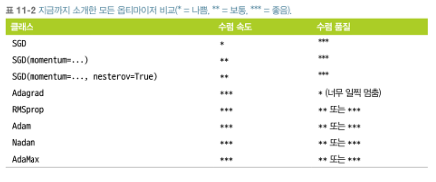

### 학습률 스케쥴링

In [4]:
# 학습률을 너무 크게 잡으면 훈련이 발산할 수 있으며, 너무 작으면 최적점에 수렴하는데 시간이 오래 걸린다.
## 컴퓨팅 자원이 한정적이라면 차선의 솔루션을 만들기 위해 완전히 수렴 전 훈련을 멈춰야 한다.

# 큰 학습률로 시작하고, 학습 속도가 느려질 때 학습률을 낮추는 전략을 학습 스케쥴이라고 한다.

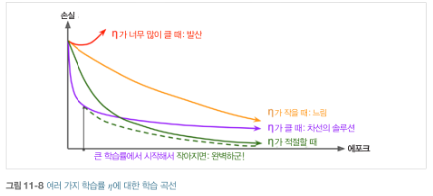

#### 거듭제곱 기반 스케쥴링

In [5]:
# lr = lr0 / (1 + steps / s)**c
# 케라스 에서는 c = 1 , s = 1 / decay 를 사용한다.

optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

#### 지수 기반 스케쥴링

In [6]:
# lr = lr0 * 0.1**(epoch / s)

def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [8]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [15]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [16]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 12s 6ms/step - loss: 1.1181 - accuracy: 0.7311 - val_loss: 0.5952 - val_accuracy: 0.8084
Epoch 2/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.6411 - accuracy: 0.8006 - val_loss: 0.7283 - val_accuracy: 0.8006
Epoch 3/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.6144 - accuracy: 0.8137 - val_loss: 0.7303 - val_accuracy: 0.8002
Epoch 4/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.6008 - accuracy: 0.8177 - val_loss: 0.6136 - val_accuracy: 0.7960
Epoch 5/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5110 - accuracy: 0.8403 - val_loss: 0.6389 - val_accuracy: 0.8300
Epoch 6/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4516 - accuracy: 0.8539 - val_loss: 0.4933 - val_accuracy: 0.8494
Epoch 7/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4215 - accuracy: 0.8662 - val_loss: 0.4984 - val_ac

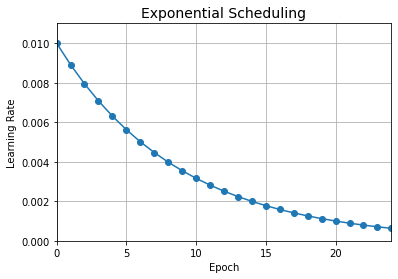

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

#### 성능 기반 스케쥴링

In [18]:
# 최상의 검증 손실이 다섯 번의 연속적인 에포크 동안 향상되지 않을 때마다 학습률에 0.5를 곱한다.

lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7201 - accuracy: 0.7736 - val_loss: 0.4925 - val_accuracy: 0.8416
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4933 - accuracy: 0.8364 - val_loss: 0.5172 - val_accuracy: 0.8402
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5114 - accuracy: 0.8400 - val_loss: 0.7130 - val_accuracy: 0.7992
Epoch 4/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4678 - accuracy: 0.8565 - val_loss: 0.4411 - val_accuracy: 0.8624
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4616 - accuracy: 0.8608 - val_loss: 0.5052 - val_accuracy: 0.8574
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5112 - accuracy: 0.8544 - val_loss: 0.5110 - val_accuracy: 0.8536
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5064 - accuracy: 0.8583 - val_loss: 0.5164 - val_accuracy:

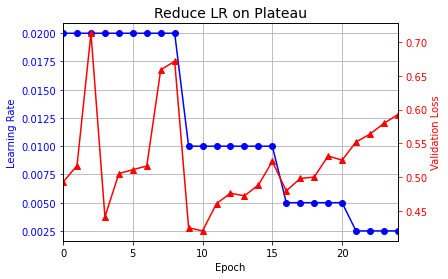

In [19]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()


#### <b>tf.keras 스케쥴러</b>

In [20]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 #  20번 에포크에 담긴 전체 스텝 수 (배치크기 = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6072 - accuracy: 0.7873 - val_loss: 0.3994 - val_accuracy: 0.8638
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3918 - accuracy: 0.8603 - val_loss: 0.3802 - val_accuracy: 0.8688
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3531 - accuracy: 0.8732 - val_loss: 0.3577 - val_accuracy: 0.8740
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3258 - accuracy: 0.8822 - val_loss: 0.3479 - val_accuracy: 0.8766
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3075 - accuracy: 0.8898 - val_loss: 0.3471 - val_accuracy: 0.8792
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2915 - accuracy: 0.8973 - val_loss: 0.3401 - val_accuracy: 0.8796
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2836 - accuracy: 0.9003 - val_loss: 0.3347 - val_accuracy:

#### 1사이클 스케쥴링

In [24]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = len(X) // batch_size * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [25]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

430/430 [==============================] - 3s 7ms/step - loss: nan - accuracy: 0.3010


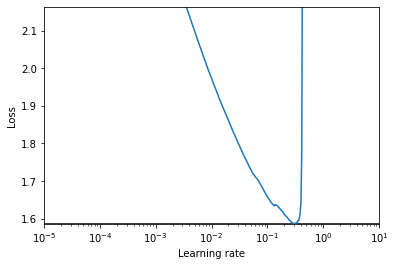

In [27]:
import numpy as np
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [28]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [29]:
n_epochs = 25
onecycle = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 3s 7ms/step - loss: 0.6498 - accuracy: 0.7750 - val_loss: 0.4809 - val_accuracy: 0.8362
Epoch 2/25
430/430 [==============================] - 3s 7ms/step - loss: 0.4590 - accuracy: 0.8393 - val_loss: 0.4284 - val_accuracy: 0.8562
Epoch 3/25
430/430 [==============================] - 3s 6ms/step - loss: 0.4124 - accuracy: 0.8558 - val_loss: 0.4091 - val_accuracy: 0.8650
Epoch 4/25
430/430 [==============================] - 3s 6ms/step - loss: 0.3846 - accuracy: 0.8644 - val_loss: 0.3828 - val_accuracy: 0.8692
Epoch 5/25
430/430 [==============================] - 3s 6ms/step - loss: 0.3626 - accuracy: 0.8709 - val_loss: 0.3783 - val_accuracy: 0.8734
Epoch 6/25
430/430 [==============================] - 3s 6ms/step - loss: 0.3449 - accuracy: 0.8766 - val_loss: 0.3681 - val_accuracy: 0.8772
Epoch 7/25
430/430 [==============================] - 3s 6ms/step - loss: 0.3293 - accuracy: 0.8819 - val_loss: 0.3620 - val_accuracy: 0.8786
Epoch 

## 규제를 사용해 과대적합 피하기

In [ ]:
# 심층 신경망은 전형적으로 수만개에서 수백만개의 파라미터를 가지고 있다.
# 이때문에 네트워크의 자유도가 매우 높으며, 대규모의 복잡한 데이터셋을 학습할 수 있다는 뜻이다.
# 하지만 이런 높은 자유도로 인해 네트워크를 훈련세트에 과대적합 되기 쉽게 만든다.
## => 규제가 필요함.

### l1 과 l2 규제

In [21]:
# 신경망의 연결 가중치를 제한하기 위해 l2 규제를 사용하거나,
# 많은 가중치가 0인 희소모델을 만들기 위해 l1 규제를 사용할 수 있다.

layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# l2 함수는 훈련하는 동안 규제 손실을 계산하기 위해
## 각 스텝에서 호출되는 규제 객체를 반환하며, 이 손실은 최종 손실에 합산된다.

### 드롭아웃

In [ ]:
# 매 훈련 스텝에서 각 뉴런은 임시적으로 드롭아웃될 확률 p를 가진다.
# p는 드롭아웃 비율이라 하고, 보통 10% ~ 50% 사이를 지정한다.
# 일반적으로 출력층을 제외한 맨 위의 층부터 세번째 층까지 있는 뉴런에만 드롭아웃을 적용한다.

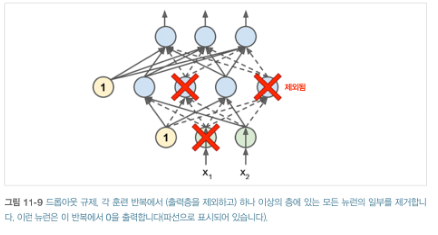

In [22]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

# 드롭아웃은 훈련하는 동안에만 활성화 되므로, 훈련 손실과 검증 손실을 비교하면 오해가 생기기 쉽다.
# 비슷한 훈련 손실과 검증 손실을 얻었더라도 모델이 훈련 세트에 과대적합 될 수 있다.
# 따라서 훈련이 끝난 뒤, 드롭아웃을 빼고 훈련 손실을 평가해야 한다.

# 모델이 과대적합 되었다면 드롭아웃 비율을 늘리고, 과소적합 되었다면 드롭아웃 비율을 낮춰야 한다.
# 층이 클 때는 드롭아웃을 늘리고, 작은층에는 드롭아웃 비율을 낮추는 것이 도움이 된다.

# 많은 최신의 신경망 구조는 마지막 은닉층 뒤에만 드롭아웃을 사용한다.
## 드롭아웃을 전체 적용하는 것이 너무 강하다면 이런 시도가 적합하다.

Epoch 1/2
1719/1719 [==============================] - 11s 6ms/step - loss: 0.7445 - accuracy: 0.7582 - val_loss: 0.3791 - val_accuracy: 0.8640
Epoch 2/2
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4291 - accuracy: 0.8411 - val_loss: 0.3442 - val_accuracy: 0.8740


In [23]:
# SELU 활성화 함수를 기반으로 자기 정규화 하는 네트워크의 규제가 필요하면
# AlphaDropOut을 사용해야 한다.

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.8017 - accuracy: 0.7153 - val_loss: 0.6558 - val_accuracy: 0.8276
Epoch 2/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5667 - accuracy: 0.7904 - val_loss: 0.5488 - val_accuracy: 0.8456
Epoch 3/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5323 - accuracy: 0.8018 - val_loss: 0.5684 - val_accuracy: 0.8418
Epoch 4/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5101 - accuracy: 0.8102 - val_loss: 0.4959 - val_accuracy: 0.8540
Epoch 5/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4972 - accuracy: 0.8175 - val_loss: 0.4688 - val_accuracy: 0.8568
Epoch 6/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4825 - accuracy: 0.8223 - val_loss: 0.5153 - val_accuracy: 0.8548
Epoch 7/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4668 - accuracy: 0.8251 - val_loss: 0.4918 - val_accuracy:

## 요약 및 실용적 가이드라인

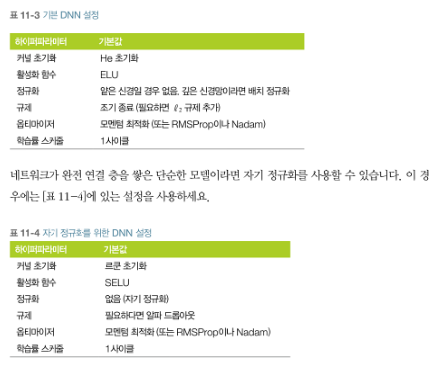

In [ ]:
# 입력 특성의 정규화는 필수이다.
# 비슷한 문제를 해결한 모델을 찾을 수 있다면 사전훈련된 신경망의 일부를 재사용해봐야 한다.
# 레이블이 없는 데이터가 많다면 비지도 사전훈련을 사용.
# 비슷한 작업을 위한 레이블된 데이터가 많다면 보조 작업에서 사전 훈련을 수행 할 수 있다.

# 예외
# 1. 희소모델이 필요할 시 l1 규제를 사용할 수 있다.
# 2. 빠른 응답을 하는 모델이 필요하면 층 갯수를 줄이고, 배치 정규화 층을 이전 층에 합친다.
## LeakyReLU 나 ReLU와 같이 빠른 활성화 함수를 사용한다.
## 희소모델을 만드는 것도 도움이 된다.
# 3. 위험에 민감하고, 예측속도가 매우 중요하지 않은 어플리케이션이라면
## 성능을 올리고 불확실성 추정과 신뢰할 수 있는 확률 추정을 얻기 위해 MC 드롭아웃을 사용할 수 있다.